In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import itertools
import time

from sklearn.decomposition import PCA
import scipy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.distributions as distributions
from torchvision.utils import make_grid
from torchvision import transforms

import pickle
import os
import sys
from tqdm.notebook import tqdm

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 2
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

# <center>Deep Generative Models</center>
## <center>Seminar 3</center>

<center><img src="pics/AIMastersLogo.png" width=600 /></center>
<center>26.09.2022</center>


## Plan

0. CNN intro
    
    - CNN for image classification example

1. Autoregressive models. Notes and Questions
    
    - 2D categorical distribution from image data recap
    
    - Arbitrary ordering of autoregressive conditionals
    
    - Gaussian autoregressive models. Ordering matters!

3. Latent Variable Modeling 

    - Gaussian Mixture Models (GMM) (theory and practice)
    
    - Principial Component Analysis (PCA)

## CNN intro

In [4]:
def load_dataset(flatten=False):
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return (data / np.float32(256)).squeeze()

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([-1, 28**2])
        X_val = X_val.reshape([-1, 28**2])
        X_test = X_test.reshape([-1, 28**2])


    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

(50000, 28, 28) (50000,)


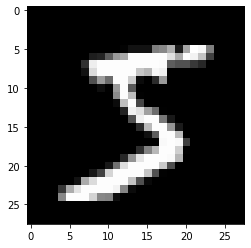

In [5]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=False)
print(X_train.shape, y_train.shape)

plt.imshow(X_train[0], cmap='gray')

Pytorch Dataset for MNIST

In [6]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform=None):
        super().__init__()
        assert len(X) == len(y)
        self.x = X
        self.y = y.astype(np.int64)
        self.transform = transform
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x, y = self.x[idx], self.y[idx]
        if self.transform is not None:
            x = self.transform(x)
        return x, y

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(), # Normalize to range [0, 1], reshape HWC to CHW
    transforms.Normalize((0.5, ), (0.5, ))
])

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(
        size=(28,28),
        scale=(0.9, 1.1),
        ratio=(0.9, 1.1)
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

train_dataset = MNISTDataset(X_train, y_train, transform=transform)

In [8]:
print(len(train_dataset))
x, y = train_dataset[10]
print(x.shape)

50000
torch.Size([1, 28, 28])


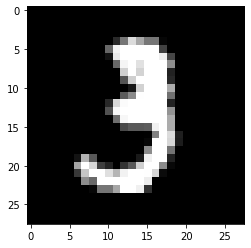

In [9]:
def draw_tensor_image(t, normalize=True, range=(-1, 1), **kwargs):
    if t.ndim == 4:
        t = make_grid(t, normalize=normalize, range=range, **kwargs)
    assert t.ndim == 3
    img = np.transpose(t.numpy(), (1, 2, 0))
    cmap = None
    if img.shape[-1] == 1:
        img = np.squeeze(img, axis=-1)
        cmap = 'gray'
    plt.imshow(img, cmap=cmap)
    
draw_tensor_image(x)

Pytorch Dataloader

In [10]:
batch_size = 32
num_workers = 0  # set 0 for Windows (or enjoy bugs)

train_loader = torch.utils.data.DataLoader(
    train_dataset,  # descendant of torch.utils.data.Dataset
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=None,  # how to create batch from separate examples
    drop_last=False,  # drop incomplete batch
    worker_init_fn=None,  # may be useful to set workers different random seeds
)

1563
tensor([8, 6, 8, 1, 0, 5, 9, 2, 6, 9, 7, 9, 2, 4, 7, 6, 1, 4, 2, 7, 1, 8, 1, 5,
        9, 2, 9, 0, 1, 9, 1, 2])


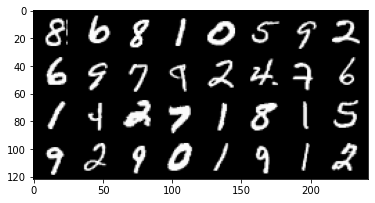

In [11]:
print(len(train_loader))
for batch_image, batch_target in train_loader:
    break
draw_tensor_image(batch_image)
print(batch_target)

In [12]:
valid_loader = torch.utils.data.DataLoader(
    MNISTDataset(X_val, y_val, transform=transform),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)
test_loader = torch.utils.data.DataLoader(
    MNISTDataset(X_test, y_test, transform=transform),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

**CNN**s example

In [15]:
model1 = nn.Sequential(
    nn.Conv2d(1, 16, 5, 2),  #12x12
    nn.ReLU(),
    nn.Conv2d(16, 32, 3),  #10x10
    nn.ReLU(),
    nn.Conv2d(32, 64, 3),  #8x8
    nn.ReLU(),
    nn.Conv2d(64, 128, 3, 2), #3x3
    nn.ReLU(),
    nn.modules.Flatten(),
    nn.Linear(128*9, 10)
)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(4*4*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model2 = CNN()

Training

In [16]:
def acc(logits, targets):
    return torch.sum(logits.max(-1)[1] == targets)/len(targets)

def run_loader(loader, train=True, device='cpu'):
    model.train(train)
    
    losses = []
    accs = []
    for batch_image, batch_target in loader:
        # move inputs to device
        batch_image = batch_image.to(device)
        batch_target = batch_target.to(device)
        # forward
        logits = model(batch_image)
        loss = loss_fn(logits, batch_target)
        # backward
        if train:
            loss.backward()
            # update all params
            optimizer.step()
            optimizer.zero_grad()
        # update metrics
        losses.append(loss.item())
        accs.append(acc(logits, batch_target).item())
    
    return np.mean(losses), np.mean(accs)

epochs = 5
lr = 1e-3

model = model1.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
loss_fn = nn.CrossEntropyLoss().to(DEVICE)  # combines nn.LogSoftmax() and nn.NCELoss()

In [17]:
for e in range(epochs):
    # timing
    time_start = time.time()
    # train
    train_loss, train_acc = run_loader(train_loader, train=True, device=DEVICE)
    
    # validation
    val_loss, val_acc = run_loader(valid_loader, train=False, device=DEVICE)
    
    # timing
    epoch_time = time.time() - time_start
    
    print(f"[Epoch {e:2d}]: loss={train_loss:.3f}, val_loss={val_loss:.3f}, "
          f"acc={train_acc:.3f}, val_acc={val_acc:.3f}, epoch_time={epoch_time:.2f}")

[Epoch  0]: loss=2.297, val_loss=2.289, acc=0.159, val_acc=0.139, epoch_time=8.55
[Epoch  1]: loss=2.270, val_loss=2.232, acc=0.178, val_acc=0.244, epoch_time=8.27
[Epoch  2]: loss=1.780, val_loss=0.807, acc=0.472, val_acc=0.766, epoch_time=8.24
[Epoch  3]: loss=0.627, val_loss=0.488, acc=0.810, val_acc=0.852, epoch_time=8.13
[Epoch  4]: loss=0.490, val_loss=0.422, acc=0.854, val_acc=0.876, epoch_time=8.19


## Autoregressive models. Notes and Questions

### 2D categorical distribution from image data 

$x_1 \in \{1, 2, \dots, 64\}$, $x_2 \in \{1, 2, \dots, 64\}$. 

$p(x_1, x_2) \sim \text{Categorical}(\boldsymbol{\theta}) \,,\, \boldsymbol{\theta} = (\theta_1, \theta_2, \dots \theta_{64 \cdot 64})$

Likelihood factorization: 

$p(x_1, x_2) = p(x_1) \cdot p(x_2 | x_1)$

$p(x_1) \sim \text{Categorical}(\boldsymbol{\psi}) \,,\,  \boldsymbol{\psi} = (\psi_1, \psi_2, \dots \psi_{64})$

$p(x_2 | x_1) \sim \text{Categorical}\left(\boldsymbol{\xi}(x_1)\right) \,,\,  \boldsymbol{\xi}(x_1) = \left(\xi_1(x_1), \xi_2(x_1), \dots \xi_{64}(x_1)\right)$

**Image data**

<center><img src="pics/2d_distribution.png" width=400 /></center>

In [19]:
def generate_2d_data(count, bins=64):
    # Загружаем картинку, сжимаем к размеру (bins x bins),
    # конвертируем к grayscale - формату
    im = Image.open('pics/2d_distribution.png').resize((bins, bins)).convert('L')
    im = np.array(im).astype('float32')
    # Сейчас im : np.array размера (64, 64), 
    # элементы этого массива выглядят так:
    # 
    # array([[12., 12., 13., ...,  6.,  6.,  4.],
    #        [11., 13., 15., ...,  7.,  6.,  6.],
    #        [14., 16., 18., ...,  7.,  7.,  6.],
    #        ...,
    #        [24., 21., 25., ..., 31., 31., 24.],
    #        [18., 21., 21., ..., 26., 26., 23.],
    #        [17., 18., 20., ..., 28., 21., 19.]], dtype=float32)
    #
    # "0." - чёрный; "255." - белый

    # Здесь мы получаем двумерное категориальное распределение, 
    # с числом параметров 64 * 64
    # КОТОРОЕ МЫ И ХОТИМ ПРИБЛИЗИТЬ НАШЕЙ МОДЕЛЬЮ
    dist = im / im.sum()

    
    ### СЕМПЛИРОВАНИЕ ИЗ dist
    # pairs перечисляет все возможные пиксели
    # pairs = [(0, 0), (0, 1), ... (63, 62), (63, 63)]
    pairs = list(itertools.product(range(bins), range(bins)))
    # выбираем count пикселей в соответствии с вероятностями из dist
    idxs = np.random.choice(len(pairs), size=count, replace=True, p=dist.reshape(-1))
    samples = np.array([pairs[i] for i in idxs])

    split = int(0.8 * len(samples))
    return dist, samples[:split], samples[split:]

In [20]:
def plot_2d_data(train_data, test_data, bins):
    train_dist, test_dist = np.zeros((bins, bins)), np.zeros((bins, bins))
    for i in range(len(train_data)):
        train_dist[train_data[i][0], train_data[i][1]] += 1
    train_dist /= train_dist.sum()

    for i in range(len(test_data)):
        test_dist[test_data[i][0], test_data[i][1]] += 1
    test_dist /= test_dist.sum()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    ax1.set_title('Train Data')
    ax1.imshow(train_dist, cmap='gray')
    ax1.axis('off')
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x0')

    ax2.set_title('Test Data')
    ax2.imshow(test_dist, cmap='gray')
    ax2.axis('off')
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x0')

    plt.show()

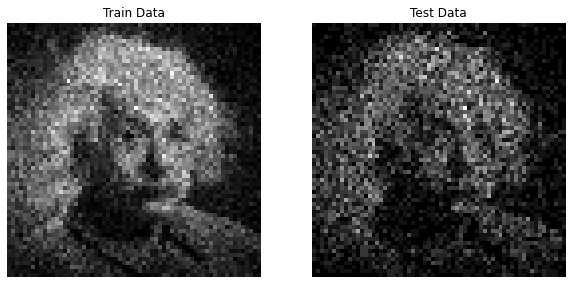

In [22]:
COUNT = 50000
BINS = 64

image, train_data, test_data = generate_2d_data(COUNT, bins=BINS)
plot_2d_data(train_data, test_data, BINS)

## Arbitrary ordering of autoregressive conditionals

Let $\boldsymbol{x} \sim p(\boldsymbol{x} | \theta) \, , \, \boldsymbol{x} \in \mathbf{R}^d$

### Direct ordering

**Log Likelihood factorization**: $\log p(\boldsymbol{x} | \theta) = \sum\limits_{j = 1}^d \log p\left( x_i | \boldsymbol{x}_{1:j-1} , \theta\right)$

**Sampling procedure**:

* Sample $\hat{x}_1 \sim p(x_1 | \theta)$

* Sample $\hat{x}_2 \sim p(x_2 | \hat{x}_1 \theta)$

* ...

* Sample $\hat{x}_d \sim p(x_d | \hat{\boldsymbol{x}}_{1:d-1} , \theta)$


### Arbitrary ordering

Let $\pi$ is permutation (перестановка) of elements $(1, 2, \dots, d)$

**Log Likelihood factorization**: $\log p(\boldsymbol{x} | \theta) = \sum\limits_{j = 1}^d \log p\left( x_{\pi_i} | x_{\pi_{1}}, x_{\pi_{2}} , \dots, x_{\pi_{j - 1}},  \theta\right) = \sum\limits_{j = 1}^d \log p\left( x_{\pi_i} | \boldsymbol{x}_{\pi_{1:j-1}} , \theta\right)$

**Sampling procedure**:

* Sample $\hat{x}_{\pi_1} \sim p(x_{\pi_1} | \theta)$

* Sample $\hat{x}_{\pi_2} \sim p(x_{\pi_2} | \hat{x}_{\pi_1} \theta)$

* ...

* Sample $\hat{x}_{\pi_d} \sim p(x_{\pi_d} | \hat{\boldsymbol{x}}_{\pi_{1:d-1}} , \theta)$

## Gaussian autoregressive models

Let $\boldsymbol{x} \sim p(\boldsymbol{x} | \theta) \, , \, \boldsymbol{x} \in \mathbf{R}^d$

**Likelihood factorization**: $p(\boldsymbol{x} | \theta) = \prod\limits_{j = 1}^{d} p\left( x_j | \boldsymbol{x}_{1:j-1}, \theta \right) \approx \prod\limits_{j = 1}^{d} \mathcal{N}\left(x_j \,\middle|\, \mu_j(\boldsymbol{x}_{1:j-1}, \theta), \sigma_j^2(\boldsymbol{x}_{1:j-1}, \theta)\right)$

**Sampling procedure**:

* Sample $\hat{x}_1 \sim \mathcal{N}\left(\mu_1(\theta), \sigma_1^2(\theta)\right)$

* Sample $\hat{x}_2 \sim \mathcal{N}\left(\mu_2(\hat{x}_1, \theta), \sigma_2^2(\hat{x}_1, \theta)\right)$

* ...

* Sample $\hat{x}_d \sim \mathcal{N}\left( \mu_d(\hat{\boldsymbol{x}}_{\pi_{1:d-1}}, \theta), \sigma_d^2(\hat{\boldsymbol{x}}_{\pi_{1:d-1}}, \theta)\right)$

### Gaussian MADE

In [23]:
from dgm_utils import train_model, plot_training_curves, show_samples
from dgm_utils import visualize_2d_samples, visualize_2d_densities, visualize_2d_data

**"Banana" distribution**

In [24]:
class BananaDistribution:
    
    def __init__(self, inv=False, device='cpu'):
        self.inv = inv
        self.x2_distrib = distributions.Normal(
            torch.tensor(0.0).to(device), 
            torch.tensor(3.3).to(device))
        self.x1_distrib = distributions.Normal(
            torch.tensor(0.0).to(device),
            torch.tensor(1.).to(device))
        
    def sample(self, count):
        x2 = self.x2_distrib.sample((count,))
        x1 = self.x1_distrib.sample((count,)) + (x2**2)/8.
        samples = torch.stack([x1, x2], axis=-1)
        if self.inv:
            samples = samples.flip(-1)
        return samples
    
    def log_prob(self, samples):
        if self.inv:
            samples = samples.flip(-1)
        x2 = samples[..., 1]
        x1 = samples[..., 0]
        log_prob_x2 = self.x2_distrib.log_prob(x2)
        log_prob_x1 = self.x1_distrib.log_prob(x1 - (x2**2)/8.)
        return log_prob_x2 + log_prob_x1
    
    def prob(self, samples):
        return torch.exp(self.log_prob(samples))

**"Banana" distribution** pdf and samples

In [25]:
N_TRAIN_SAMPLES = 240000
N_TEST_SAMPLES = 60000

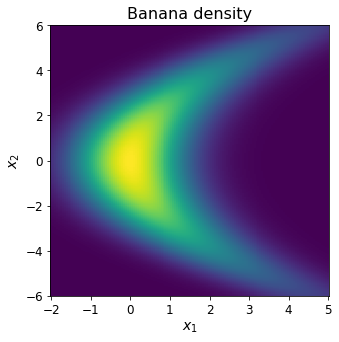

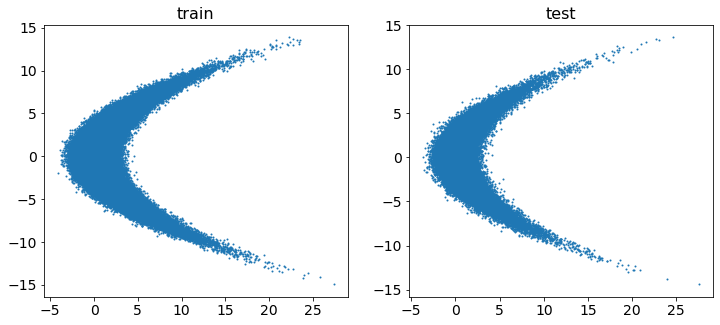

In [26]:
banana_generator = BananaDistribution()

################
## Density visualization

dx, dy = 0.05, 0.05
x_lim = (-2, 5)
y_lim = (-6, 6)
y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                slice(x_lim[0], x_lim[1] + dx, dx)]

mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2)).to(DEVICE)
densities = banana_generator.prob(mesh_xs).cpu().detach().numpy()
visualize_2d_densities(x, y, densities, title='Banana density', xlabel=r'$x_1$', ylabel=r'$x_2$')

##################
## Dataset

banana_data_train = banana_generator.sample(N_TRAIN_SAMPLES)
banana_data_test = banana_generator.sample(N_TEST_SAMPLES)

visualize_2d_data(
    banana_data_train.cpu().numpy(), 
    banana_data_test.cpu().numpy())

Inverted **"Banana" distribution"** pdf and samples

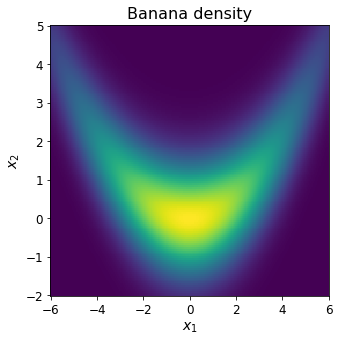

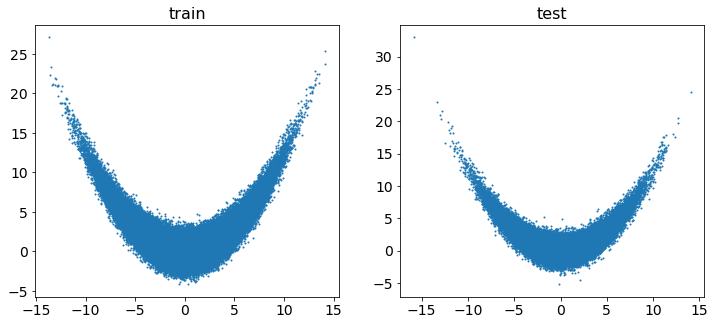

In [27]:
inv_banana_generator = BananaDistribution(inv=True)

################
## Density visualization

dx, dy = 0.05, 0.05
x_lim = (-6, 6)
y_lim = (-2, 5)
y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                slice(x_lim[0], x_lim[1] + dx, dx)]

mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2)).to(DEVICE)
densities = inv_banana_generator.prob(mesh_xs).cpu().detach().numpy()
visualize_2d_densities(x, y, densities, title='Banana density', xlabel=r'$x_1$', ylabel=r'$x_2$')

##################
## Dataset

inv_banana_data_train = inv_banana_generator.sample(N_TRAIN_SAMPLES)
inv_banana_data_test = inv_banana_generator.sample(N_TEST_SAMPLES)

visualize_2d_data(
    inv_banana_data_train.cpu().numpy(), 
    inv_banana_data_test.cpu().numpy())

### Made on Banana dataset

In [49]:
class MaskedLinear(torch.nn.Linear):
    
    
    def __init__(self, in_features, out_features):
        super().__init__(in_features, out_features)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))

    def forward(self, input):
         
        return torch.nn.functional.linear(input, self.mask * self.weight, self.bias)

In [29]:
class MADE(torch.nn.Module):
    
    def __init__(self, nin, hidden_sizes):
        '''
        :Parameters:
        nin : int : number of input dimensions
        hidden_sizes : list : sizes of hidden layers
        '''
        super().__init__()
        
        
        self.nin = nin # 2
        self.nout = nin * 2 # \mu an \sigma per each dimension
        
        self.hidden_sizes = hidden_sizes
        # we will use the trivial ordering of input units
        self.ordering = np.arange(self.nin)
        
        
        self.net = []
        hs = [self.nin,] + self.hidden_sizes + [self.nout]
        for h0, h1 in zip(hs[:-2], hs[1:-1]):
            self.net.extend([
                MaskedLinear(h0, h1),
                torch.nn.ReLU(),
            ])
            
        
        self.net.append(MaskedLinear(hs[-2], hs[-1]))
        self.net = torch.nn.Sequential(*self.net)

        self.create_mask()  # builds the initial self.m connectivity


    def create_mask(self):
        
        # 1) The ordering of input units from 1 to d (self.ordering).
        # 2) Assign the random number k from 1 to d − 1 to each hidden unit. 
        #    This number gives the maximum number of input units to which the unit can be connected.
        # 3) Each hidden unit with number k is connected with the previous layer units 
        #   which has the number less or equal than k.
        # 4) Each output unit with number k is connected with the previous layer units 
        #    which has the number less than k.

        self.assigned_numbers = {}
        self.masks = []
        L = len(self.hidden_sizes)
        
        # sample the order of the inputs and the connectivity of all neurons
        self.assigned_numbers[-1] = self.ordering
        for l in range(L):
            self.assigned_numbers[l] = np.random.randint(self.assigned_numbers[l - 1].min(), 
                                      self.nin - 1, size=self.hidden_sizes[l])
            
            
        # construct the mask matrices
        masks = [self.assigned_numbers[l - 1][:, None] <= self.assigned_numbers[l][None, :] for l in range(L)]
        masks.append(self.assigned_numbers[L - 1][:, None] < self.assigned_numbers[-1][None, :])

        masks[-1] = np.repeat(masks[-1], 2, axis=1)  
#         masks[0] = np.repeat(masks[0], , axis=0)
        
        self.masks = masks 
       

        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l, m in zip(layers, masks):
            l.set_mask(m)

    
    def visualize_masks(self):
        prod = self.masks[0]
        for idx, m in enumerate(self.masks):
            plt.figure(figsize=(3, 3))
            plt.title(f'layer: {idx}')
            plt.imshow(m.T, vmin=0, vmax=1, cmap='gray')
            plt.show()

            if idx > 0:
                prod=prod.dot(m)

        plt.figure(figsize=(3, 3))
        plt.title('prod')
        plt.imshow(prod.T, vmin=0, vmax=1, cmap='gray')
        plt.show()

    
    def forward(self, x):
        
        """
        :Parameters:
        x: torch.Size([BS,2]) : input sample
        :Output:
        out : torch.Size([BS, 2, 2]) : output 
        """
        
        assert len(x.size()) == 2
        assert x.shape[1] == self.nin
        batch_size = x.shape[0]
     
        # 1) apply one hot encoding to x
        # 2) apply the model
        # 3) reshape and transpose the output to (batch_size, self.bins, self.nin)
        
        logits = self.net(x)
        # torch.tensor ([B,4])
        
        logits = logits.view(batch_size, self.nin, 2)
        mus = logits[..., 0]
        log_sigmas = logits[..., 1]
        
        return mus, log_sigmas
    
    def loss(self, x):
        nll = - self.log_prob(x)
        total_loss = nll.mean()
        return {'total_loss': total_loss}
    
    def log_prob(self, x):
        mus, log_sigmas = self(x)
        assert mus.size(-1) == 2
        assert log_sigmas.size(-1) == 2
        nll = (x - mus).pow(2)/torch.exp(log_sigmas * 2) + log_sigmas
        return -nll.sum(-1)
    
    def prob(self, x):
        return torch.exp(self.log_prob(x))

**"Banana" distribution** learning

In [83]:
HIDDEN_SIZES = [20, 20, 20]

model = MADE(2, HIDDEN_SIZES).to(DEVICE)
# model.visualize_masks()

In [84]:
BATCH_SIZE = 256
EPOCHS = 2
LR = 0.01

train_loader = data.DataLoader(banana_data_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(banana_data_train, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, lr=LR)

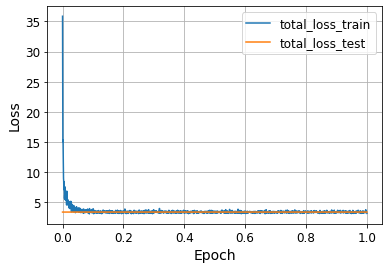

In [85]:
plot_training_curves(train_losses, test_losses)

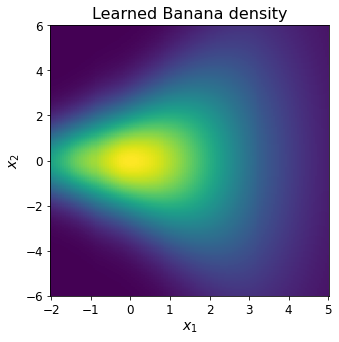

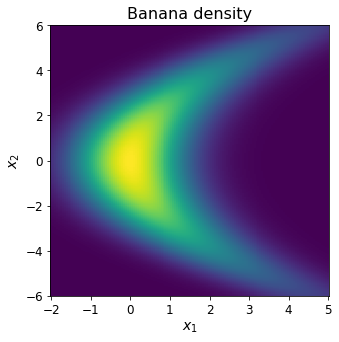

In [86]:
################
## Density visualization
model.eval()

dx, dy = 0.05, 0.05
x_lim = (-2, 5)
y_lim = (-6, 6)
y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                slice(x_lim[0], x_lim[1] + dx, dx)]

mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2)).to(DEVICE)

#### Learned distribution visualization
with torch.no_grad():
    learned_densities = model.prob(mesh_xs).cpu().detach().numpy()
visualize_2d_densities(
    x, y, 
    learned_densities, 
    title='Learned Banana density', xlabel=r'$x_1$', ylabel=r'$x_2$')

#### Original distribution visualization
original_densities = banana_generator.prob(mesh_xs).cpu().detach().numpy()
visualize_2d_densities(
    x, y, 
    original_densities, title='Banana density', xlabel=r'$x_1$', ylabel=r'$x_2$')

**Question.** Why does the learned and original distributions are different?

Inverted **"Banana" distribution** learning

In [87]:
HIDDEN_SIZES = [20, 20, 20]

np.random.seed(36)
model = MADE(2, HIDDEN_SIZES).to(DEVICE)
# model.visualize_masks()

In [88]:
BATCH_SIZE = 256
EPOCHS = 2
LR = 0.01

train_loader = data.DataLoader(inv_banana_data_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(inv_banana_data_train, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, lr=LR)

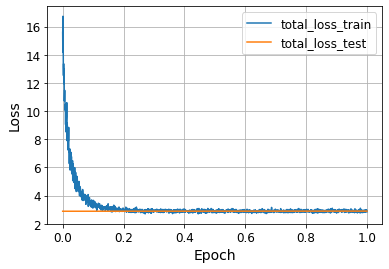

In [89]:
plot_training_curves(train_losses, test_losses)

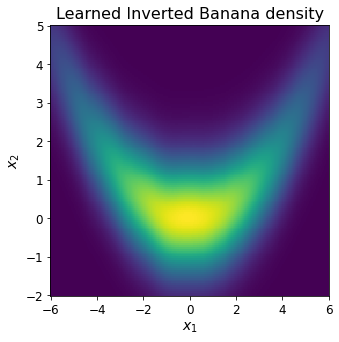

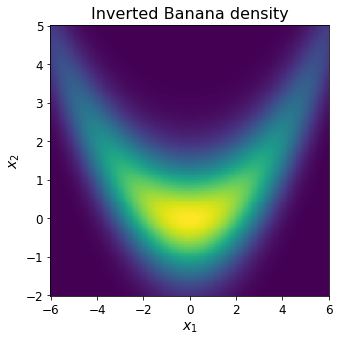

In [90]:
################
## Density visualization

model.eval()

dx, dy = 0.05, 0.05
x_lim = (-6, 6)
y_lim = (-2, 5)
y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                slice(x_lim[0], x_lim[1] + dx, dx)]

mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2)).to(DEVICE)

#### Learned distribution visualization
with torch.no_grad():
    learned_densities = model.prob(mesh_xs).cpu().detach().numpy()
visualize_2d_densities(
    x, y, 
    learned_densities, 
    title='Learned Inverted Banana density', xlabel=r'$x_1$', ylabel=r'$x_2$')

#### Original distribution visualization
original_densities = inv_banana_generator.prob(mesh_xs).cpu().detach().numpy()
visualize_2d_densities(
    x, y, 
    original_densities, title='Inverted Banana density', xlabel=r'$x_1$', ylabel=r'$x_2$')

### Gaussian MADE

**Conclusion.** The order of conditioning matters! (in case of Gaussian MADE)

**Question.** How to fix the dependence on order of conditioning?

1. Consider more general classes of distributions ($p(x_j | \boldsymbol{x}_{1:j-1} , \theta) \sim \text{Mixture of Gaussians}$ or $\text{Mixture of Logistics}$).  

    For example, `CharCNN++` [link](https://arxiv.org/pdf/1701.05517.pdf) utilizes mixture of logistics.
    
    <span style="color:green"> *Will be covered in future lectures and seminars* </span>
    
2. Stack Gaussian MADE layers (which results in `MAF` [link](https://arxiv.org/pdf/1705.07057.pdf) - Masked Autoregressive Flow)

    <span style="color:green"> *Autoregressive flows will be covered in future lectures and seminars* </span>

## Latent Variables Model

<center><img src="pics/lvm_diagram.png" width=600 /></center>

**Advantages**

1. Latent space could describe high-level features of the data:

<center><img src="pics/celeba_interpolation.png" width=300 /></center>

2. the distributions $p(x | z)$ and $p(z)$ could be rather simple:
    
    * Example: $p(x|z) = \mathcal{N}(\boldsymbol{\mu}(z), \boldsymbol{\Sigma}(z))$, $p(z) = \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma})$
    
3. It is beneficial to model $p(z | x)$

<center><img src="pics/image_restoration.png" width=300 /></center>


**Likelihood**

$p(x |\theta) = \int\limits_{\mathcal{Z}} p(x | z, \theta) p(z| \theta) dz$

**Sampling procedure**

* Sample $z^* \sim p(z | \theta)$

* Sample $x \sim p(x | z^*, \theta)$

**Question.** What problems arise when learning Latent Variables Models?

### Gaussian Mixture Models

$p(z | \theta) = \text{Categorical}(\pi_1, \dots \pi_k)$

$p(\boldsymbol{x} | z, \theta) = \mathcal{N}\left(\boldsymbol{x}|, \boldsymbol{\mu}_z, \boldsymbol{\Sigma}_z\right)$

**Likelihood** of the model?

$p(x | \theta) = \sum\limits_{i = 1}^{k}  \pi_i \mathcal{N}\left(x - \boldsymbol{\mu}_i, \boldsymbol{\Sigma}_i\right)$

In [30]:
from scipy.stats import multivariate_normal

class GMM:

    def __init__(self, k, dim, mu=None, sigma=None, pi=None):
        '''
        Define a model with known number of clusters and dimensions.
        :Parameters:
            - k: Number of Gaussian clusters
            - dim: Dimension 
            - mu: means of clusters (k, dim)
                       (default) random from uniform[-10, 10]
            - sigma: covariance matrices of clusters (k, dim, dim)
                          (default) Identity matrix for each cluster
            - pi: cluster weights (k,)
                       (default) equal value to all cluster i.e. 1/k
        '''
        self.k = k
        self.dim = dim
        if mu is None:
            mu = np.random.rand(k, dim)*20 - 10
        self.mu = mu
        if sigma is None :
            sigma = np.zeros((k, dim, dim))
            for i in range(k):
                sigma[i] = np.eye(dim)
        self.sigma = sigma
        if pi is None:
            pi = np.ones(self.k)/self.k
        self.pi = pi
    
    def log_prob(self, X):
        '''
        Compute the log-prob of each element in X
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of each element in X: log Sum_k pi_k * N( X_i | mu_k, sigma_k ))
        '''
        return np.log(self.prob(X))
    
    def prob(self, X):
        '''
        Compute the prob of each element in X
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of each element in X: Sum_k pi_k * N( X_i | mu_k, sigma_k )
        '''
        prob = 0
        for i in range(self.k):
            curr_prob = self.pi[i] * multivariate_normal.pdf(X, mean=self.mu[i], cov=self.sigma[i])
            prob += curr_prob
        return prob
    
    def log_likelihood(self, X):
        '''
        Compute the log-likelihood of X
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of X: Sum_n Sum_k log(pi_k * N( X_n | mu_k, sigma_k ))
        '''
        return np.sum(self.log_prob(X))
        

GMM visualization

In [170]:
def draw_contour(density, X, Y, n_levels=3):
    plt.figure(figsize=(5, 5))
    density = density.reshape(X.shape)
    levels = np.linspace(np.min(density), np.max(density), n_levels)
    plt.contour(X, Y, density, levels=levels)
    plt.show()

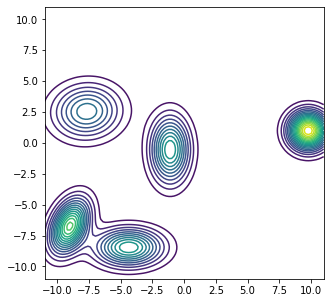

In [185]:
np.random.seed(45)
sigmas = np.array([
    [[1., 0.], [0., 1]],
    [[3., 0.], [0., 1]],
    [[1., 0.], [0., 3]],
    [[1., 0.5], [  0.5, 2.]],
    [[3., 0.1], [0.1, 2]]
])

gmm = GMM(5, 2, sigma=sigmas)

dx, dy = 0.2, 0.2
x_lim = (-11, 11)
y_lim = (-11, 11)
y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                slice(x_lim[0], x_lim[1] + dx, dx)]
mesh_xs = np.stack([x, y], axis=2).reshape(-1, 2)
densities = gmm.prob(mesh_xs)
draw_contour(densities, x, y, n_levels=20)

**Question.**

How to fit GMM model to data $X_1, \dots X_n$ from unknown distribution?

- One can try likelihood maximization

- EM algorithm (will be explained soon)

## PCA



<center><img src="pics/pca.png" width=300 /></center>

Let $X_1, \dots, X_n \in \mathbb{R}^D$

$\max\limits_{\boldsymbol{e}_1, \dots \boldsymbol{e}_d} \sum\limits_{j = 1}^{d}\left(\frac{1}{n} \sum\limits_{i = 1}^n \langle \boldsymbol{e}_j, X_i\rangle  - \langle \boldsymbol{e}_j, \overline{X}\rangle\right)$, where $\boldsymbol{e}_j \in \mathbb{R}^D\, , \, \Vert \boldsymbol{e}_j \Vert_2 = 1 \, , \, \boldsymbol{e}_j \perp \boldsymbol{e}_i$

* Original $\rightarrow$ Compressed:

    $y = \begin{bmatrix}\boldsymbol{e}_1^T \\ \dots \\ \boldsymbol{e}_d^T\end{bmatrix} (X - \overline{X})$

* Compressed $\rightarrow$ Original:

    $\hat{X} = \overline{X} + \begin{bmatrix} \boldsymbol{e}_1 & \dots & \boldsymbol{e}_d \end{bmatrix} y$
    
* Complexity: 
    * $O(D n \min(D, n))$ (SVD)
    * $O(d D^2)$ (first $d$ eigenvectors via Power method) + $O(n D^2)$ for covariance matrix constuction

### PCA for data compression

Load the dataset of human faces. Each image has dimensions $32\times32$. The images are grayscaled and flattened.

In [ ]:
X = np.loadtxt('./data/train_faces.npy')
print(X)
print(X.shape)

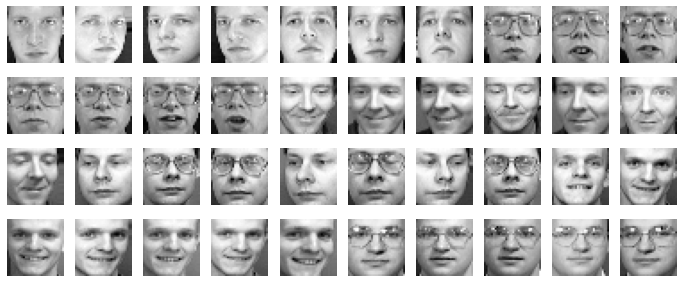

In [188]:
plt.figure(figsize=(12, 5))    
for i in range(40):
    plt.subplot(4, 10, i + 1)
    plt.imshow(X[i].reshape((32, 32)), cmap='gray')
    plt.axis('off')

Visualization in $2D$ space

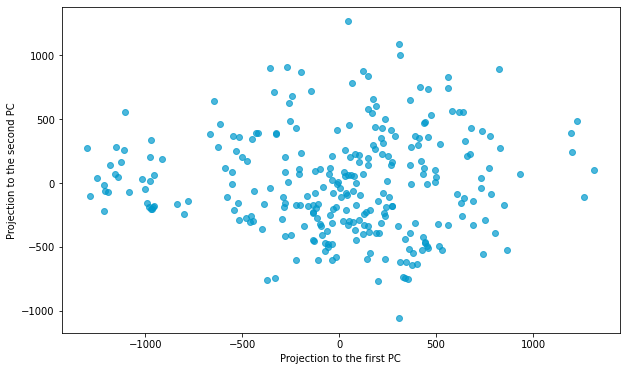

In [189]:
pca = PCA(n_components=2)
transform_X = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(transform_X[:, 0], transform_X[:, 1], 
            alpha=0.7, color='#0099CC')
plt.xlabel('Projection to the first PC')
plt.ylabel('Projection to the second PC')
plt.show()

Unexplained variance (доля необъясненной дисперсии)

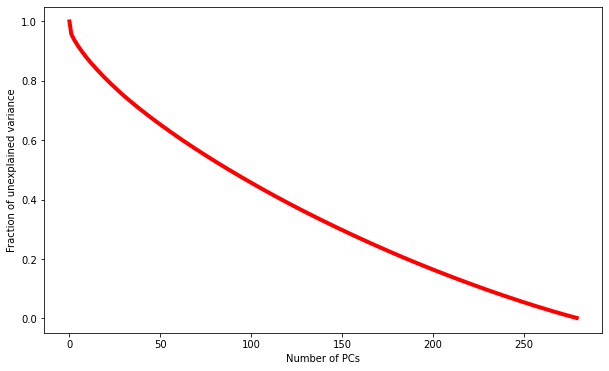

In [194]:
singular_values = np.sqrt(scipy.linalg.svdvals(X))
error = singular_values[::-1].cumsum() / singular_values.sum()
error = error[::-1]

plt.figure(figsize=(10, 6))
plt.plot(range(len(error)), error, c='red', linewidth=4)
plt.xlabel('Number of PCs')
plt.ylabel('Fraction of unexplained variance')
plt.show()

Visualization of Principial Components

In [195]:
pca = PCA(n_components=50)
transform_X = pca.fit_transform(X)

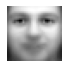

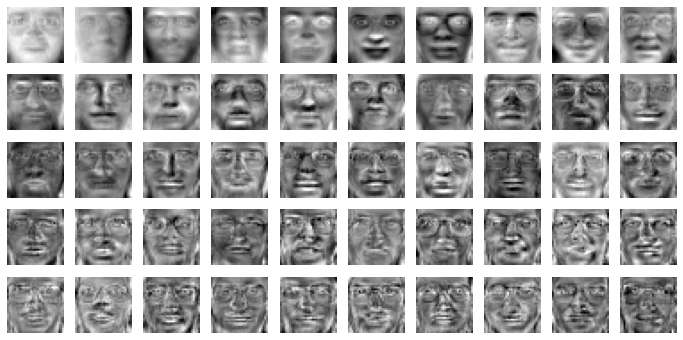

In [196]:
plt.figure(figsize=(1, 1))
plt.imshow(pca.mean_.reshape((32, 32)), cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(12, 6))    
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(pca.components_[i].reshape((32, 32)), cmap='gray')
    plt.axis('off')

Data restoration based on the first Principial Components

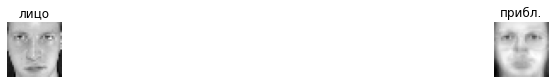

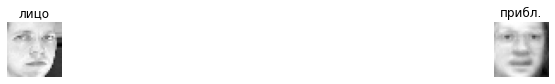

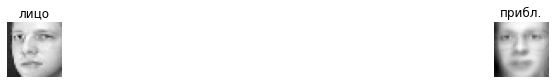

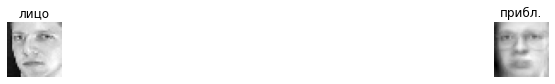

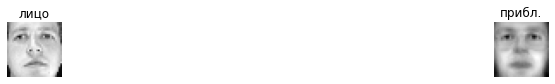

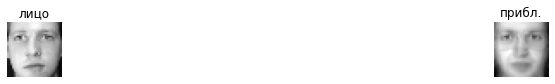

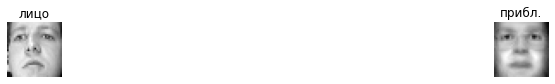

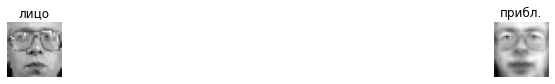

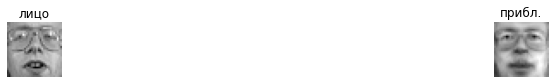

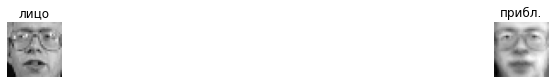

In [199]:
N_COMPONENTS = 10

pca = PCA(n_components=N_COMPONENTS)
transform_X = pca.fit_transform(X)

for i in range(10):
    X_hat = pca.inverse_transform(transform_X[i])
    plt.figure(figsize=(16, 1))
    
    plt.subplot(1, 2, 1)
    plt.imshow(X[i].reshape((32, 32)), cmap='gray')
    plt.axis('off')
    plt.title('лицо')
    
    plt.subplot(1, 2, 2)
    plt.imshow(X_hat.reshape((32, 32)), cmap='gray')
    plt.axis('off')
    plt.title('прибл.')
        
    plt.show()